<a href="https://colab.research.google.com/github/Federico-Villa/TAM-2025-2/blob/main/taller_parcial_22_09_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

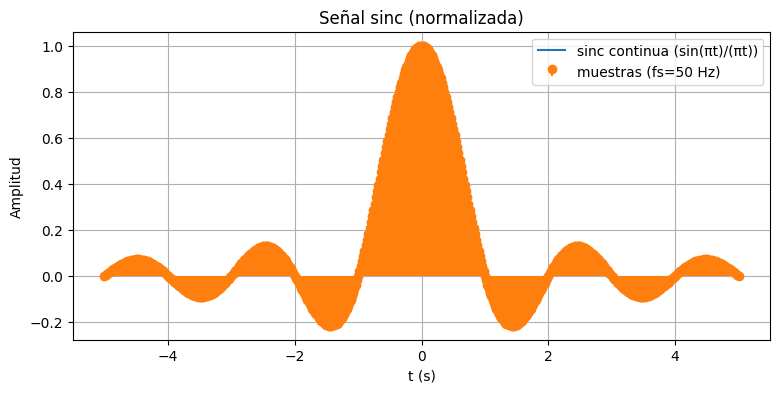

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
t_min, t_max = -5, 5
n_cont = 2001  # puntos para la versión "continua"
fs = 50        # frecuencia de muestreo
Ts = 1 / fs

# Tiempo continuo y sinc
t_cont = np.linspace(t_min, t_max, n_cont)
x_cont = np.sinc(t_cont)  # np.sinc ya implementa sin(pi*x)/(pi*x)

# Tiempo muestreado y sinc
t_s = np.arange(t_min, t_max + Ts, Ts)
x_s = np.sinc(t_s)

# Gráfica
plt.figure(figsize=(9,4))
plt.plot(t_cont, x_cont, label='sinc continua (sin(πt)/(πt))')
plt.stem(t_s, x_s, linefmt='C1-', markerfmt='C1o', basefmt=" ", label=f'muestras (fs={fs} Hz)')
plt.xlabel('t (s)')
plt.ylabel('Amplitud')
plt.title('Señal sinc (normalizada)')
plt.grid(True)
plt.legend()
plt.show()


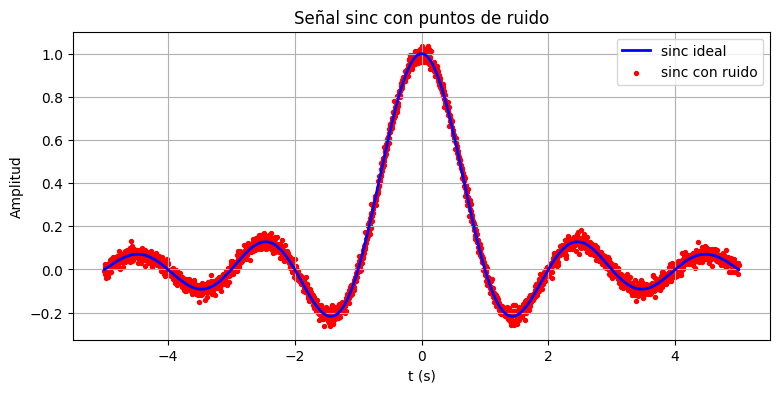

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
t_min, t_max = -5, 5
n_cont = 2300
ruido_std = 0.02  # intensidad del ruido

# Tiempo continuo y sinc ideal
t_cont = np.linspace(t_min, t_max, n_cont)
x_cont = np.sinc(t_cont)

# Señal ruidosa
ruido = np.random.normal(0, ruido_std, size=t_cont.shape)
x_ruidosa = x_cont + ruido

# Gráfica
plt.figure(figsize=(9,4))
plt.plot(t_cont, x_cont, label='sinc ideal', linewidth=2, color='blue')
plt.scatter(t_cont, x_ruidosa, color='red', s=8, label='sinc con ruido')
plt.xlabel('t (s)')
plt.ylabel('Amplitud')
plt.title('Señal sinc con puntos de ruido')
plt.grid(True)
plt.legend()
plt.show()


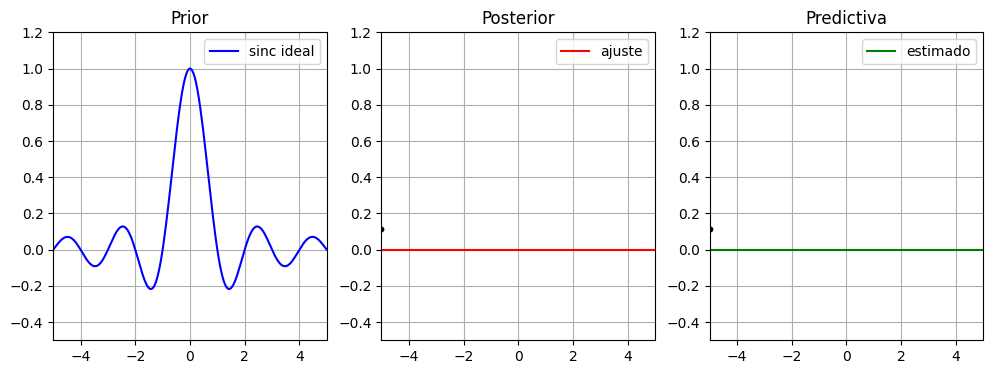

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# --- Datos base ---
t_min, t_max = -5, 5
n_cont = 200
ruido_std = 0.1

# Dominio
t = np.linspace(t_min, t_max, n_cont).reshape(-1,1)
y_true = np.sinc(t).ravel()

# Datos ruidosos (observaciones)
y_noisy = y_true + np.random.normal(0, ruido_std, size=y_true.shape)

# --- Ajuste polinómico como "posterior" ---
# (para simplificar usamos regresión polinómica en lugar de fórmulas bayesianas)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def fit_model(t_obs, y_obs, grado=9):
    poly = PolynomialFeatures(grado)
    X_poly = poly.fit_transform(t_obs)
    model = LinearRegression().fit(X_poly, y_obs)
    y_pred = model.predict(poly.transform(t))
    return y_pred

# --- Figura con 3 columnas (prior, posterior, predictiva) ---
fig, ax = plt.subplots(1, 3, figsize=(12,4))

for a in ax:
    a.set_xlim(t_min, t_max)
    a.set_ylim(-0.5, 1.2)
    a.grid(True)

ax[0].set_title("Prior")
ax[1].set_title("Posterior")
ax[2].set_title("Predictiva")

# Prior (sinc ideal)
ax[0].plot(t, y_true, color="blue", label="sinc ideal")
ax[0].legend()

# Gráficos dinámicos
posterior_line, = ax[1].plot([], [], color="red", label="ajuste")
posterior_points = ax[1].scatter([], [], color="black", s=10)

predict_line, = ax[2].plot([], [], color="green", label="estimado")
predict_points = ax[2].scatter([], [], color="black", s=10)

for a in ax:
    a.legend()

# --- Función de actualización ---
def update(i):
    # Tomar primeras i observaciones
    t_obs = t[:i]
    y_obs = y_noisy[:i]

    # Ajustar modelo (posterior/predictiva)
    if len(t_obs) > 2:
        y_fit = fit_model(t_obs, y_obs, grado=9)
    else:
        y_fit = np.zeros_like(y_true)

    # Posterior
    posterior_line.set_data(t, y_fit)
    posterior_points.set_offsets(np.c_[t_obs, y_obs])

    # Predictiva (igual que posterior aquí)
    predict_line.set_data(t, y_fit)
    predict_points.set_offsets(np.c_[t_obs, y_obs])

    return posterior_line, posterior_points, predict_line, predict_points

# --- Animación ---
frames = np.linspace(1, n_cont, 30, dtype=int)
anim = animation.FuncAnimation(fig, update, frames=frames, blit=False, repeat=False)

rc('animation', html='jshtml')
HTML(anim.to_jshtml())


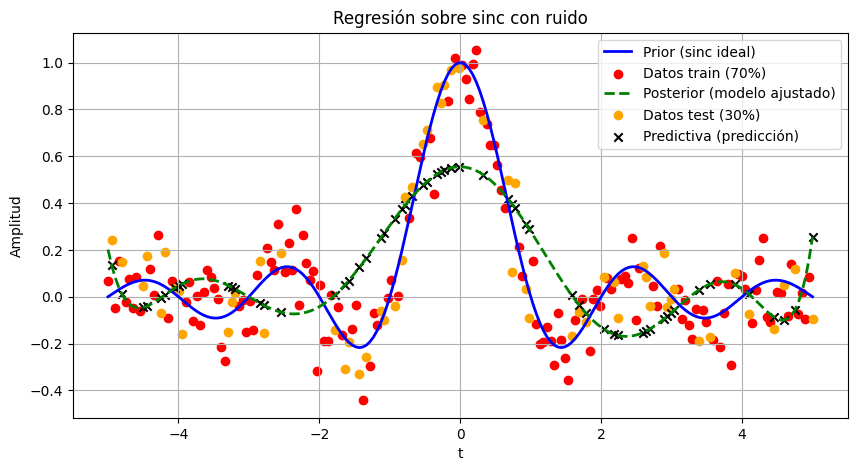

Error cuadrático medio (MSE) en test: 0.0531


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


t_min, t_max = -5, 5
n_puntos = 200
ruido_std = 0.1

# Dominio y sinc ideal
t = np.linspace(t_min, t_max, n_puntos).reshape(-1,1)
y_true = np.sinc(t).ravel()

# Señal ruidosa (observaciones)
y_noisy = y_true + np.random.normal(0, ruido_std, size=y_true.shape)
n_train = int(0.7 * n_puntos)
indices = np.random.permutation(n_puntos)

train_idx = indices[:n_train]
test_idx  = indices[n_train:]

t_train, y_train = t[train_idx], y_noisy[train_idx]
t_test,  y_test  = t[test_idx],  y_noisy[test_idx]
grado = 9  # polinomio de grado 9
poly = PolynomialFeatures(grado)
X_train_poly = poly.fit_transform(t_train)

modelo = LinearRegression().fit(X_train_poly, y_train)

X_test_poly = poly.transform(t_test)
y_pred_test = modelo.predict(X_test_poly)

# Para graficar en todo el dominio
y_pred_all = modelo.predict(poly.transform(t))

plt.figure(figsize=(10,5))

# Prior
plt.plot(t, y_true, 'b', linewidth=2, label='Prior (sinc ideal)')

# Posterior (ajuste usando solo train)
plt.scatter(t_train, y_train, c='red', label='Datos train (70%)')
plt.plot(t, y_pred_all, 'g--', linewidth=2, label='Posterior (modelo ajustado)')

# Predictiva (predicciones sobre test)
plt.scatter(t_test, y_test, c='orange', label='Datos test (30%)')
plt.scatter(t_test, y_pred_test, c='black', marker='x', label='Predictiva (predicción)')

plt.title("Regresión sobre sinc con ruido")
plt.xlabel("t")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.show()
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"Error cuadrático medio (MSE) en test: {mse_test:.4f}")


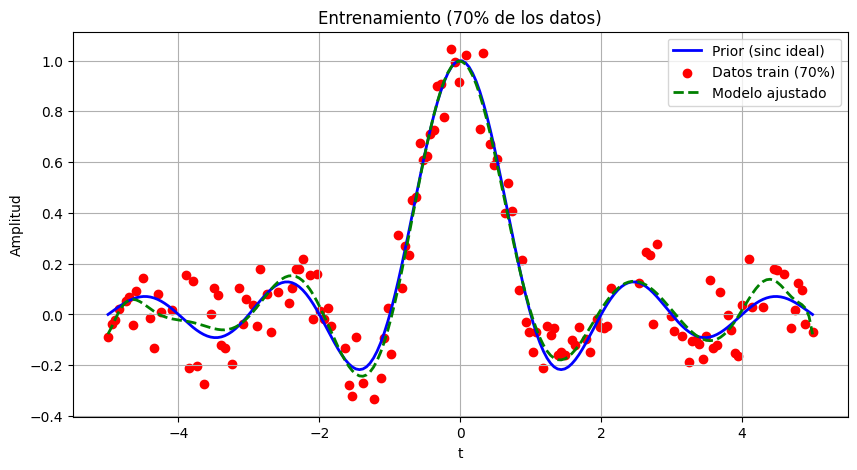

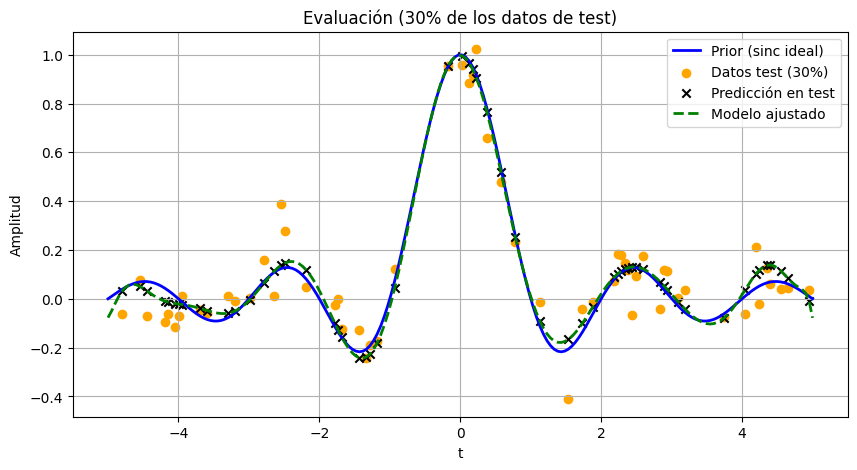

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# -----------------------------
# Generación de datos
# -----------------------------
t_min, t_max = -5, 5
n_puntos = 200
ruido_std = 0.1

# Dominio y sinc ideal
t = np.linspace(t_min, t_max, n_puntos).reshape(-1,1)
y_true = np.sinc(t).ravel()

# Señal ruidosa
y_noisy = y_true + np.random.normal(0, ruido_std, size=y_true.shape)

# Partición train/test
n_train = int(0.7 * n_puntos)
indices = np.random.permutation(n_puntos)
train_idx = indices[:n_train]
test_idx  = indices[n_train:]

t_train, y_train = t[train_idx], y_noisy[train_idx]
t_test,  y_test  = t[test_idx],  y_noisy[test_idx]

# -----------------------------
# Modelo polinómico
# -----------------------------
grado = 18
poly = PolynomialFeatures(grado)

# Ajuste con train
X_train_poly = poly.fit_transform(t_train)
modelo = LinearRegression().fit(X_train_poly, y_train)

# Predicciones
y_pred_train = modelo.predict(poly.transform(t_train))
y_pred_test  = modelo.predict(poly.transform(t_test))
y_pred_all   = modelo.predict(poly.transform(t))

# -----------------------------
# Gráfica 1: entrenamiento
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(t, y_true, 'b', linewidth=2, label="Prior (sinc ideal)")
plt.scatter(t_train, y_train, c='red', label="Datos train (70%)")
plt.plot(t, y_pred_all, 'g--', linewidth=2, label="Modelo ajustado")
plt.title("Entrenamiento (70% de los datos)")
plt.xlabel("t")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Gráfica 2: test
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(t, y_true, 'b', linewidth=2, label="Prior (sinc ideal)")
plt.scatter(t_test, y_test, c='orange', label="Datos test (30%)")
plt.scatter(t_test, y_pred_test, c='black', marker='x', label="Predicción en test")
plt.plot(t, y_pred_all, 'g--', linewidth=2, label="Modelo ajustado")
plt.title("Evaluación (30% de los datos de test)")
plt.xlabel("t")
plt.ylabel("Amplitud")
plt.grid(True)
plt.legend()
plt.show()
